## **CNN CANCER DECTECTION PROJECT**

### **1) Description of problem and data**

#### **1.1) Challenge problem:**

This mini-project is based on the Histopathologic Cancer Detection Kaggle competition. The goal is to build a binary image classification model that can automatically identify whether a small patch of tissue (96 × 96 pixels) contains metastatic cancer. For each 96×96 RGB patch, predict the probability that the center 32x32 region contains tumor tissue. Metric is AUC-ROC.

#### **1.2) Dataset description:**

***Data Type:***

The dataset consists of RGB image patches in .tif format. Each image represents a small section of a larger pathology slide, and the goal is to detect whether the patch contains metastatic cancer tissue.

***Size and dimension:***

Image size: 96x96 pixels

Dimension: Each image has shape (96,96,3).

***Data structure:***

Training set: folder with ≈ 220 000 images.

Test set: folder with ≈ 57500 images.

train_labels.csv: contains two columns:

  + id: unique identifier of each image

  + label: target value (1 = tumor, 0 = normal tissue)

The submission file required output format (id, label).

### **2) Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**
#### **2.1) Load data**

In [1]:
import pandas as pd, numpy as np, torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, models
from pathlib import Path
import json, random, time
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
ROOT = '/content/drive/MyDrive'
CSV_PATH  = f'{ROOT}/train_labels.csv'
df = pd.read_csv(CSV_PATH)
print(df.head(), '\n')
print(df.info(),'\n')

Mounted at /content/drive
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None 



In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import random
from pathlib import Path
TRAIN_ZIP = f'{ROOT}/train.zip'
TEST_ZIP  = f'{ROOT}/test.zip'

# Create folders and unzip
!mkdir -p /content/data/train
!mkdir -p /content/data/test

!unzip -q "$TRAIN_ZIP" -d /content/data/train
!unzip -q "$TEST_ZIP"  -d /content/data/test



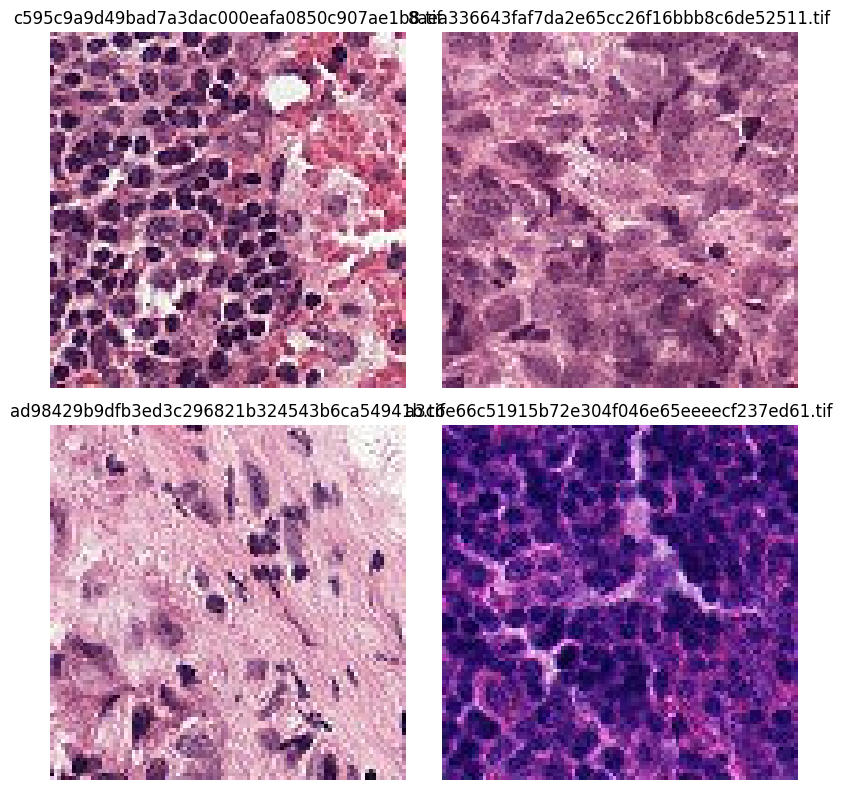

In [4]:
# Convert TRAIN_DIR from string to Path
TRAIN_DIR = Path("/content/data/train/train")
TEST_DIR  = Path("/content/data/test/test")
# Pick 4 random images from train folder
sample_files = random.sample(list(TRAIN_DIR.glob("*.tif")), 4)

# Display them
plt.figure(figsize=(8,8))
for i, img_path in enumerate(sample_files):
    img = Image.open(img_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_path.name)
plt.tight_layout()
plt.show()

#### **2.2) Label distribution**

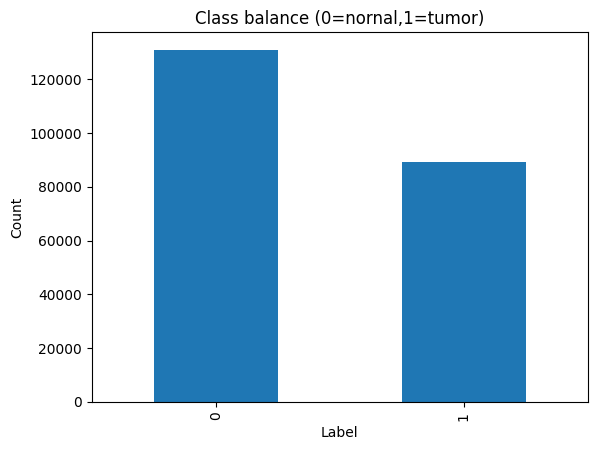

Possitive ratio:  40.503%


In [ ]:
counts=df['label'].value_counts().sort_index()
ax=counts.plot(kind='bar')
ax.set_title('Class balance (0=nornal,1=tumor)')
ax.set_xlabel('Label'); ax.set_ylabel('Count')
plt.show()
pos_ratio=counts.get(1,0)/counts.sum()
print(f"Possitive ratio: {pos_ratio: .3%}")

#### **2.3) Pixel intensity histogram**

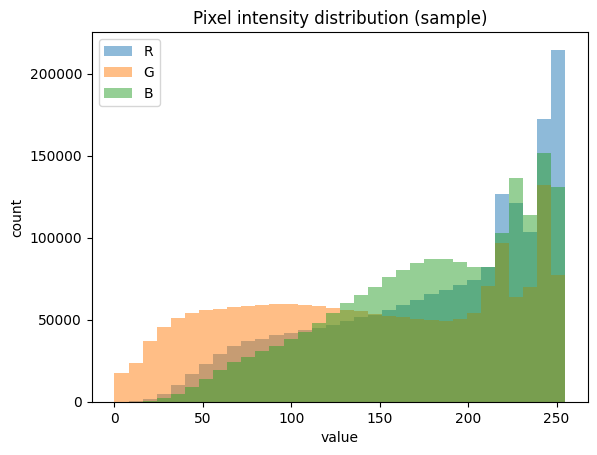

In [ ]:
def pixel_histogram(sample_ids, n_samples=200):
    vals=[]
    for _id in sample_ids.sample(min(n_samples, len(sample_ids)), random_state=1):
        im = np.array(Image.open(TRAIN_DIR/f"{_id}.tif").convert("RGB"), dtype=np.uint8)
        vals.append(im.reshape(-1,3))
    vals=np.concatenate(vals, axis=0)
    plt.figure()
    plt.hist(vals[:,0], bins=32, alpha=0.5, label='R')
    plt.hist(vals[:,1], bins=32, alpha=0.5, label='G')
    plt.hist(vals[:,2], bins=32, alpha=0.5, label='B')
    plt.title("Pixel intensity distribution (sample)")
    plt.legend(); plt.xlabel("value"); plt.ylabel("count")
    plt.show()
pixel_histogram(df['id'])

#### **2.4) Visual inspection of patches (tumor vs normal)**

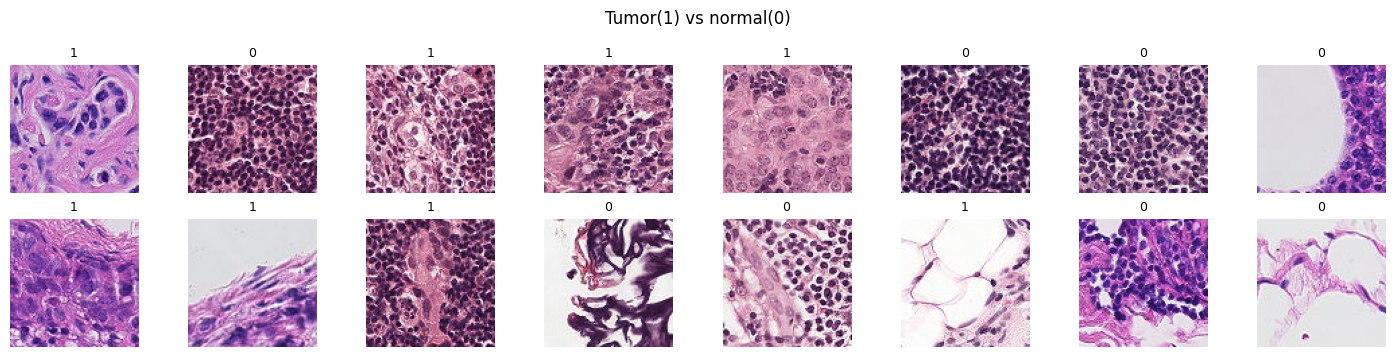

In [ ]:
import math
def show_grid(sample_df, n=16, cols=8, title="Sample training patches"):
    rows=math.ceil(n/cols)
    plt.figure(figsize=(cols*1.8, rows*1.8))
    for i, r in enumerate(sample_df.sample(min(n, len(sample_df)), random_state=123).itertuples(),1):
        img=Image.open(TRAIN_DIR/f"{r.id}.tif").convert("RGB")
        plt.subplot(rows, cols,i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(int(r.label), fontsize=9)
    plt.suptitle(title); plt.tight_layout(); plt.show()
pos=df[df.label==1].sample(min(8,(df.label==1).sum()), random_state=1)
neg=df[df.label==0].sample(min(8, (df.label==0).sum()), random_state=1)
show_grid(pd.concat([pos,neg], ignore_index=True), n=16, cols=8, title='Tumor(1) vs normal(0)')


#### **2.5) Data cleanning**
- Missing or corrupted images were identified and removed.
- Removing duplicate IDs or conflicting labels.
- Confirm image dimensions are consistent

In [ ]:
print("Duplicates(entire rows):", df.duplicated().sum())
print("Duplicate IDs:", df['id'].duplicated().sum())
print("Missing values:\n", df.isna().sum())

missing=[]
for _id in df['id'].sample(min(5000, len(df)), random_state=42):
    if not (TRAIN_DIR/f"{id}.tif").exists():
        missing.append(_id)
print("Missing image files among sample:", len(missing))

sizes=[]
for _id in df['id'].sample(50, random_state=0):
    with Image.open(TRAIN_DIR/f"{_id}.tif") as im:
        sizes.append(im.size)
print("Unique size in sample:", set(sizes))

Duplicates(entire rows): 0
Duplicate IDs: 0
Missing values:
 id          0
label       0
filepath    0
dtype: int64
Missing image files among sample: 5000
Unique size in sample: {(96, 96)}


In [ ]:
# Drop duplicate IDs
df_clean=df.drop_duplicates(subset='id').copy()

# Keep only rows whose image actually exists
mask_exists=df_clean['id'].apply(lambda x: (TRAIN_DIR/f"{x}.tif").exists())
df_clean=df_clean[mask_exists].reset_index(drop=True)
print("After cleanning:", df_clean.shape)

After cleanning: (220025, 3)


#### **Plan of analysis**
- Classifying binary images with AUC-ROC as primary metric.
- Splits: Stratified train/validation split (80/20) using df_clean.
- Preprocessing: Convert to tensors; scale to [0,1].
- Models to compare:
  + Small CNN baseline.
  + Larger CNN
  + Transfer learning (ResNet-18) with a custom binary head.
- Training: AdamW, LR ≈ 1e-3 with scheduler, early stopping on validation AUC.
- Evaluation: Track train/val AUC & loss per epoch, plot ROC.
- Hyperparamrter tunning.
- Submission: Predict probabilities for test images, write submission.csv with columns id,label.

 ### 3) **Model architecture**
#### **3.1) Model architectures and reasoning**
##### **A) SimpleCNN**
- 1 3×3 conv layers (8 filters) + ReLU + MaxPool
- 1 fully connected layer
- Loss: BCEWithLogitsLoss
- Optimizer: Adam
##### **B) LargerCNN**
- 2 convolutional layers (16 and 32 filters)
- ReLU activation
- MaxPool
- Fully connected layer
- Loss: BCEWithLogitsLoss
- Optimizer: Adam
##### **C) ResNet-18**
- Backbone: torchvision.models.resnet18(weights="IMAGENET1K_V1")
- Transfer strategy: freeze all layers, then unfreeze only layer4 (last residual stage).
- Head: replace fc with Linear(512→1)
- Loss/Optim: same as SimpleCNN; train only the unfrozen layers + new head.
##### **Why these choice are suitable for this problem:**
- ResNet-18 + partial unfreeze: preserves robust low-level filters that transfer to microscopy; adapting only later layers learns tumor-specific arrangements with little computation.
- SimpleCNN and LargerCNN: gives a transparent baseline to ensure the pipeline (labels, loaders, metric) is correct and to evaluate the value of transfer.
##### **Compare multiple architectures:**
- SimpleCNN and LargerCNN: Fast and simple; a strong sanity check baseline. However, limited representational power; no residual connections; learns from scratch.
- ResNet-18: Much stronger representations and converges in a few epochs with good speed when most layers are frozen, but slight domain mis-match if not adapted enough.


#### **3.2) Split data and build model architectures:**

In [5]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image

TRAIN_DIR = Path("/content/data/train/train")
labels_df = df  # columns: id, label
labels_df["filepath"] = labels_df["id"].apply(
    lambda x: TRAIN_DIR / f"{x}.tif"
)

class PCamDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"])
        if self.transform:
            img = self.transform(img)
        label = int(row["label"])
        return img, label

In [6]:
from sklearn.model_selection import train_test_split
import torch.optim as optim
train_df, val_df = train_test_split(
    labels_df, test_size=0.2, random_state=42, stratify=labels_df["label"]
)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_set = PCamDataset(train_df, transform=transform)
val_set   = PCamDataset(val_df,   transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=64, shuffle=False)

num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(8*32*32, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [ ]:
class LargerCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32*16*16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [ ]:
def build_resnet18(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # freeze all layers except final classifier
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(512, num_classes)  # new classifier
    return model

### **3.2) Modeling, Evaluating and comparing multiple architectures**
#### **Build functions for trainning, evaluating and comparing**


In [11]:
def train_model(model, name, lr=0.001, epochs=3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    print(f"\nTraining {name}...")

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    return model

In [7]:
# Evaluate using accuracy metric
def evaluate(model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

In [8]:
# Evaluating using roc_auc_score
def evaluate_roc_binary(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)

            # case 1: output shape [batch, 1]  → use sigmoid
            if logits.shape[1] == 1:
                probs_pos = torch.sigmoid(logits).squeeze(1)      # P(y=1)

            # case 2: output shape [batch, 2] → use softmax and take class 1
            else:
                probs = torch.softmax(logits, dim=1)
                probs_pos = probs[:, 1]                           # P(y=1)

            all_probs.append(probs_pos.cpu())
            all_labels.append(labels.cpu())

    all_probs  = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    auc = roc_auc_score(all_labels, all_probs)
    return auc

In [ ]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA:", torch.cuda.is_available(), "| Device:", DEVICE)
if DEVICE == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


CUDA: True | Device: cuda
GPU: Tesla T4


#### **Train three models and save into results**

In [ ]:

results = {}

# A. Simple CNN
simple_cnn = SimpleCNN(num_classes)
simple_cnn = train_model(simple_cnn, "SimpleCNN", lr=0.001, epochs=3)


Training SimpleCNN...
Epoch 1: Loss = 0.4716
Epoch 2: Loss = 0.4397
Epoch 3: Loss = 0.4202


In [ ]:
results["SimpleCNN_acc"] = evaluate(simple_cnn)
results["SimpleCNN_auc"] = evaluate_roc_binary(simple_cnn,val_loader,device)

In [ ]:
# B. Larger CNN
larger_cnn = LargerCNN(num_classes)
larger_cnn = train_model(larger_cnn, "LargerCNN", lr=0.001, epochs=3)




Training LargerCNN...
Epoch 1: Loss = 0.4148
Epoch 2: Loss = 0.3474
Epoch 3: Loss = 0.3143


In [ ]:
results["LargerCNN_acc"] = evaluate(larger_cnn)
results["LargerCNN_auc"] = evaluate_roc_binary(larger_cnn,val_loader,device )

In [ ]:
# C. ResNet-18
resnet18 = build_resnet18(num_classes)
resnet18 = train_model(resnet18, "ResNet18 (pretrained)", lr=0.001, epochs=3)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 82.7MB/s]



Training ResNet18 (pretrained)...
Epoch 1: Loss = 0.4580
Epoch 2: Loss = 0.4504
Epoch 3: Loss = 0.4513


In [ ]:
results["ResNet18_acc"] = evaluate(resnet18)
results["ResNet18_auc"] = evaluate_roc_binary(resnet18,val_loader,device)

#### **Compare the results between three architectures**

In [ ]:
print("\n=== MODEL PERFORMANCE ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


=== MODEL PERFORMANCE ===
SimpleCNN_acc: 81.9475
SimpleCNN_auc: 0.8889
LargerCNN_acc: 84.9290
LargerCNN_auc: 0.9384
ResNet18_acc: 80.8226
ResNet18_auc: 0.8781


### **4) Hyperparameter tunning, results and analysis**
- Tune Learning rate: 1e-4, 3e-4, 1e-3
- Try three architectures: SimpleCNN, LargerCNN, ResNet-18
- Apply techniques to inmprove performance: learning rating scheduling, fine-tunning last ResNet layers, increase number of epochs.
#### **Tunning and show the result in table**



In [ ]:
import itertools
# List of learning rates to try
lrs = [1e-4, 3e-4, 1e-3]

EPOCHS_PER_RUN = 3

def sweep_models():
    rows = []

    model_builders = [
        ("SimpleCNN", lambda: SimpleCNN(num_classes)),
        ("LargerCNN", lambda: LargerCNN(num_classes)),
        ("ResNet18",  lambda: build_resnet18(num_classes)),
    ]

    for (name, make_model), lr in itertools.product(model_builders, lrs):
        print(f"\n=== Training {name} with lr={lr} ===")
        model = make_model()
        model = train_model(model, f"{name} (lr={lr})", lr=lr, epochs=EPOCHS_PER_RUN)

        acc = evaluate(model)
        auc = evaluate_roc_binary(model,val_loader,device)
        rows.append({
            "model": name,
            "lr": lr,
            "epochs": EPOCHS_PER_RUN,
            "accuracy": acc,
            "roc_auc": auc,
        })

    df = pd.DataFrame(rows)
    return df

In [ ]:
df_results = sweep_models()
df_results


=== Training SimpleCNN with lr=0.0001 ===

Training SimpleCNN (lr=0.0001)...
Epoch 1: Loss = 0.4988
Epoch 2: Loss = 0.4634
Epoch 3: Loss = 0.4530

=== Training SimpleCNN with lr=0.0003 ===

Training SimpleCNN (lr=0.0003)...
Epoch 1: Loss = 0.4792
Epoch 2: Loss = 0.4415
Epoch 3: Loss = 0.4183

=== Training SimpleCNN with lr=0.001 ===

Training SimpleCNN (lr=0.001)...
Epoch 1: Loss = 0.4804
Epoch 2: Loss = 0.4373
Epoch 3: Loss = 0.4252

=== Training LargerCNN with lr=0.0001 ===

Training LargerCNN (lr=0.0001)...
Epoch 1: Loss = 0.4714
Epoch 2: Loss = 0.4252
Epoch 3: Loss = 0.4080

=== Training LargerCNN with lr=0.0003 ===

Training LargerCNN (lr=0.0003)...
Epoch 1: Loss = 0.4446
Epoch 2: Loss = 0.3895
Epoch 3: Loss = 0.3628

=== Training LargerCNN with lr=0.001 ===

Training LargerCNN (lr=0.001)...
Epoch 1: Loss = 0.4278
Epoch 2: Loss = 0.3626
Epoch 3: Loss = 0.3293

=== Training ResNet18 with lr=0.0001 ===

Training ResNet18 (lr=0.0001)...
Epoch 1: Loss = 0.4906
Epoch 2: Loss = 0.4430


,model,lr,epochs,accuracy,roc_auc
0,SimpleCNN,0.0001,3,80.004545,0.867400
1,SimpleCNN,0.0003,3,81.770253,0.883986
2,SimpleCNN,0.0010,3,81.992955,0.883714
3,LargerCNN,0.0001,3,82.720145,0.899858
4,LargerCNN,0.0003,3,84.944893,0.924728
5,LargerCNN,0.0010,3,86.083400,0.934581
6,ResNet18,0.0001,3,81.054426,0.880758
7,ResNet18,0.0003,3,81.152142,0.881010
8,ResNet18,0.0010,3,80.756732,0.877802


#### **Apply techniques to improve training performance**

In [9]:
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.optim as optim
train_df, val_df = train_test_split(
    labels_df, test_size=0.2, random_state=42, stratify=labels_df["label"]
)
# For training: add augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((128, 128)),      # a bit larger, more detail
    transforms.ToTensor()
])
# For validation / test: resize
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_set = PCamDataset(train_df, transform=train_transform)
val_set   = PCamDataset(val_df,   transform=val_transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=64, shuffle=False)

# Unfreeze only the last conv block (layer4) for ResNet-18 architecture
def build_resnet18(num_classes, fine_tune_last_block=True):
    # Pretrained on ImageNet
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze everything first
    for param in model.parameters():
        param.requires_grad = False

    if fine_tune_last_block:
        # Unfreeze only the last conv block (layer4) and the fc layer
        for name, param in model.named_parameters():
            if name.startswith("layer4"):
                param.requires_grad = True

    # New classifier for our 2 classes
    model.fc = nn.Linear(512, num_classes)
    # Make sure fc is trainable
    for param in model.fc.parameters():
        param.requires_grad = True

    return model
# Increase the number of epochs
EPOCH_PER_RUN=5

In [18]:
num_classes=2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_modified = build_resnet18(num_classes)
resnet18_modified = train_model(resnet18_modified, "ResNet18 (pretrained)", lr=0.0001, epochs=5)



Training ResNet18 (pretrained)...
Epoch 1: Loss = 0.2784
Epoch 2: Loss = 0.2250
Epoch 3: Loss = 0.2030
Epoch 4: Loss = 0.1914
Epoch 5: Loss = 0.1800


In [12]:
resnet18_modified1 = build_resnet18(num_classes)
resnet18_modified1 = train_model(resnet18_modified1, "ResNet18 (pretrained)", lr=0.0003, epochs=5)



Training ResNet18 (pretrained)...
Epoch 1: Loss = 0.2707
Epoch 2: Loss = 0.2228
Epoch 3: Loss = 0.2043
Epoch 4: Loss = 0.1900
Epoch 5: Loss = 0.1809


In [13]:
resnet18_modified2 = build_resnet18(num_classes)
resnet18_modified2 = train_model(resnet18_modified2, "ResNet18 (pretrained)", lr=0.001, epochs=5)



Training ResNet18 (pretrained)...
Epoch 1: Loss = 0.2773
Epoch 2: Loss = 0.2232
Epoch 3: Loss = 0.2046
Epoch 4: Loss = 0.1913
Epoch 5: Loss = 0.1798


In [19]:
results={}
results["ResNet18_modified_acc"] = evaluate(resnet18_modified)
results["ResNet18_modified_auc"] = evaluate_roc_binary(resnet18_modified,val_loader,device)


In [ ]:
results["ResNet18_modified1_acc"] = evaluate(resnet18_modified1)
results["ResNet18_modified1_auc"] = evaluate_roc_binary(resnet18_modified1,val_loader,device)
results["ResNet18_modified2_acc"] = evaluate(resnet18_modified2)
results["ResNet18_modified2_auc"] = evaluate_roc_binary(resnet18_modified2,val_loader,device)

In [20]:
print(results)

{'ResNet18_modified_acc': 94.55743665492558, 'ResNet18_modified_auc': np.float64(0.9852199337759263)}


In [2]:
import pandas as pd
cols=['n','model','lr','epoch','roc_auc']
df_results=pd.DataFrame(columns=cols)
df_results.loc[len(df_results)] = ['1','Resnet18_modified', 0.0001, 5,0.9857799318469092 ]
df_results.loc[len(df_results)] = ['2','Resnet18_modified', 0.0003, 5,0.9856059950010177]
df_results.loc[len(df_results)] = ['3','Resnet18_modified', 0.001, 5,0.9854189950010178 ]
df_results.loc[len(df_results)] = ['4','Larger_CNN', 0.001, 3, 0.934581 ]
df_results.loc[len(df_results)] = ['5','Larger_CNN', 0.0003, 3, 0.924728 ]
df_results.loc[len(df_results)] = ['6','Larger_CNN', 0.0001, 3, 0.899858 ]
df_results.loc[len(df_results)] = ['7','Simple_CNN', 0.001, 3, 0.883714 ]
df_results.loc[len(df_results)] = ['8','Simple_CNN', 0.0003, 3, 0.883986 ]
df_results.loc[len(df_results)] = ['9','ResNet-18', 0.0001, 3, 0.880758 ]
df_results.loc[len(df_results)] = ['10','ResNet-18', 0.0003, 3, 0.881010 ]
df_results.loc[len(df_results)] = ['11','ResNet-18', 0.001, 3, 0.877802 ]
df_results.loc[len(df_results)] = ['12','Simple_CNN', 0.0001, 3, 0.867400]
df_results


,n,model,lr,epoch,roc_auc
0,1,Resnet18_modified,0.0001,5,0.985780
1,2,Resnet18_modified,0.0003,5,0.985606
2,3,Resnet18_modified,0.0010,5,0.985419
3,4,Larger_CNN,0.0010,3,0.934581
4,5,Larger_CNN,0.0003,3,0.924728
5,6,Larger_CNN,0.0001,3,0.899858
6,7,Simple_CNN,0.0010,3,0.883714
7,8,Simple_CNN,0.0003,3,0.883986
8,9,ResNet-18,0.0001,3,0.880758
9,10,ResNet-18,0.0003,3,0.881010


#### **Show the results with figure**

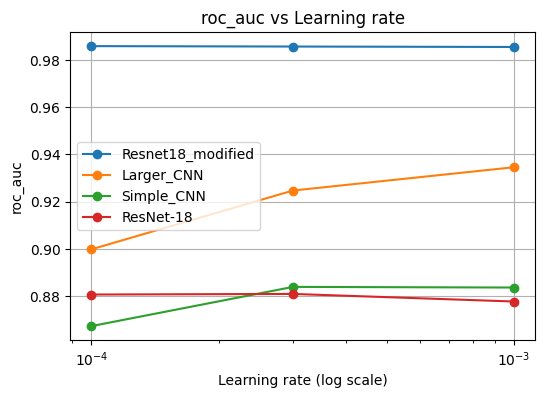

In [3]:
import matplotlib.pyplot as plt
def plot_metric(df, metric_name):
    plt.figure(figsize=(6,4))

    for model_name in df["model"].unique():
        sub = df[df["model"] == model_name].sort_values("lr")
        plt.plot(sub["lr"], sub[metric_name], marker="o", label=model_name)

    plt.xscale("log")
    plt.xlabel("Learning rate (log scale)")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} vs Learning rate")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(df_results, "roc_auc")

#### **Why something doesn't work well**

- Initially, LargerCNN achieved the best performance (≈84.9% accuracy, AUC ≈0.94) and ResNet18 performed the worst (≈80.8% accuracy, AUC ≈0.88). ResNet18 did not perform as well even though it is a much deeper network because I initially froze all ResNet18 layers and only trained the final fully connected layer. Because only the last layer was updated, the model could not fully adapt its features to this domain, so its performance was limited.
- The LargerCNN outperformed SimpleCNN because it has more convolutional filters and an additional conv layer, which allows it to capture more complex spatial patterns in the histopathology images.

#### **Trouble shooting steps:**

During development I encountered a few practical issues. At first, I tried to use ImageFolder on the raw PCam training directory, which contains only .tif files and no class subfolders. This caused a FileNotFoundError. I fixed this by creating a custom Dataset that reads file paths and labels from the CSV file.
Moreover, when visualizing random training patches, I got a “Sample larger than population” error because I tried to sample 4 images from a directory with fewer files. I fixed this by checking the number of files and using k = min(4, len(files)).

#### **Hyperparameter optimization summary**

For hyperparameter tuning, I focused on the learning rate and used a small sweep:
- Models compared: SimpleCNN, LargerCNN, ResNet18
- Learning rates tested: 1e-4, 3e-4, 1e-3
- Epochs per configuration: 3
- Metrics collected: validation accuracy and ROC-AUC.

I wrote a sweep_models() function that loops over all combinations of model architecture and learning rate, trains each model for a few epochs, evaluates it on the validation set, and stores the results in a pandas DataFrame. I then examined the table and plotted ROC-AUC vs. learning rate for each model. From this sweep I observed that very small LRs trained very slowly and sometimes underfit.
Large LRs (1e-3) occasionally caused unstable training or slightly lower AUC.

### **5) Discussion and Conclusion, Takeaways and Future Improvements**
In this project, I experimented with three different model architectures for classifying histopathology image patches: a SimpleCNN, a LargerCNN, and a pretrained ResNet-18. After a few modifications, the Resnet-18 achieved the best performance.

The SimpleCNN served as a useful baseline. Its shallow architecture with a single convolutional layer learned basic edge and texture patterns and reached reasonable accuracy and AUC. The LargerCNN improved on this by adding an extra convolutional layer and more filters. This increased capacity allowed the model to learn richer hierarchical features and better separate tumor and normal tissue.

Interestingly, ResNet-18 performed worse than LargerCNN at first, even though it is a much deeper and more powerful architecture. The main reasons is that I initially froze all pretrained ResNet layers and only trained the final fully connected layer. Because of that, ResNet-18 could not adapt its internal representations enough and was effectively acting like a fixed feature extractor with a small linear classifier on top, which limited its performance. However, adding data augmentation and fine-tunning helped the models generalize better and increased ROC-AUC in the training set, and the Resnet-18 becomes the best performance architecture.

From these experiments, the main learnings and takeaways are:
- A slightly deeper CNN (LargerCNN) outperformed both an overly simple model and a powerful model that was not properly fine-tuned.
- Pretrained models are not automatically better: ResNet-18 needs domain-appropriate fine-tuning (unfreezing later layers and using a suitable input resolution) to show its full potential.
- Hyperparameters matter: proper learning-rate selection and data augmentation can yield significant gains even without changing the architecture.

There are several potential improvements I could explore in future work:
- More careful fine-tuning of ResNet-18 (and other pretrained models).
- Unfreeze only the last few convolutional blocks instead of either freezing everything or fully training the whole network.
- Explore combinations of learning rate, batch size, optimizer type (Adam with SGD with momentum), and weight decay.
- Use validation curves and early stopping to find the best training duration without overfitting.
- Combine predictions from LargerCNN and a properly fine-tuned ResNet-18 to see if an ensemble can achieve higher ROC-AUC than any single model.


### **6) Train on test data and save a csv file to submit to Kaggle**

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Custom test dataset (no labels)
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_paths = sorted(list(img_dir.glob("*.tif")))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, img_path.name

In [ ]:
test_set = TestDataset(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
import torch

def predict_labels(model):
    model.eval()
    model.to(device)

    ids = []
    labels = []

    with torch.no_grad():
        for images, names in test_loader:
            images = images.to(device)

            outputs = model(images)             # shape [B,2]
            probs = torch.softmax(outputs, dim=1)[:, 1]  # P(class=1)

            preds = (probs > 0.5).int()         # threshold → 0 or 1

            ids.extend([n.replace(".tif", "") for n in names])
            labels.extend(preds.cpu().tolist())

    df = pd.DataFrame({
        "id": ids,
        "label": labels
    })

    return df

In [ ]:
best_model=resnet18_modified
submission = predict_labels(best_model)
submission.to_csv("submission.csv", index=False)

print("Saved to submission.csv")
submission.head()

Saved to submission.csv


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,1
4,000270442cc15af719583a8172c87cd2bd9c7746,0


### Github repository URL
https://github.com/phi-nguyen-95/CNN-Cancer-Detection